In [1]:
import os
import shutil
from typing import List, Tuple
from tqdm import tqdm
import time

import torch
import pandas as pd
from torch_geometric import data, nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

In [2]:
def z_score(x: torch.Tensor, mean: float, std: float):
    return (x - mean) / std


def un_z_score(z: torch.Tensor, mean: float, std: float):
    return (z * std) + mean

In [3]:
from typing import List, Tuple, Union


class TrafficDataset(data.InMemoryDataset):
    def __init__(
        self,
        config: dict,
        root: str,
        gat_version: bool = True,
        transform=None,
        pre_transform=None,
    ):
        self.config = config
        self.gat_version = gat_version
        super().__init__(root, transform, pre_transform)
        (
            self.data,
            self.slices,
            self.n_node,
            self.mean,
            self.std,
        ) = torch.load(self.processed_paths[0])

    # return the path of the file contains data which is processed
    @property
    def processed_file_names(self) -> str | List[str] | Tuple:
        return ["./data.pt"]

    # The path to the file contains data
    @property
    def raw_file_names(self) -> str | List[str] | Tuple:
        return [
            os.path.join(self.raw_dir, "PeMSD7_V_228.csv"),
            os.path.join(self.raw_dir, "PeMSD7_W_228.csv"),
        ]

    # download the raw dataset file
    def download(self):
        V_dest = os.path.join(self.raw_dir, "PeMSD7_V_228.csv")
        W_dest = os.path.join(self.raw_dir, "PeMSD7_W_228.csv")
        shutil.copyfile("../data/raw/PeMSD7_V_228.csv", V_dest)
        shutil.copyfile("../data/raw/PeMSD7_W_228.csv", W_dest)

    def process(self):
        df = pd.read_csv(self.raw_file_names[0], header=None)
        weight_df = pd.read_csv(self.raw_file_names[1], header=None)
        W = self._distance_to_weight(torch.from_numpy(weight_df.values))
        data_ = torch.from_numpy(df.values)
        mean = torch.mean(data_)
        std = torch.std(data_)
        data_ = z_score(data_, mean, std)
        _, num_nodes = data_.shape
        edge_index = torch.zeros((2, num_nodes**2), dtype=torch.long)
        edge_label = torch.zeros((num_nodes**2, 2))
        num_edges = 0
        # extract edge list from adjacency matrix
        for i in range(num_nodes):
            for j in range(num_nodes):
                if W[i, j] != 0:
                    edge_index[0, num_edges] = i
                    edge_index[1, num_edges] = j
                    edge_label[num_edges] = self.W[i, j]
                    num_edges += 1

        # resize edge list from number_nodes^2
        edge_index = edge_index.resize_((2, num_edges))
        edge_label = edge_label.resize_(num_edges, 1)
        sequences = self._speed2vec(
            edge_index,
            edge_label,
            num_nodes,
            self.config["N_DAYS"],
            self.config["N_SLOT"],
            data_,
            self.config["F"],
            self.config["H"],
        )
        data_, slices = self.collate(sequences)

        torch.save(
            (data_, slices, num_nodes, mean, std),
            self.processed_paths[0],
        )

    def _distance_to_weight(
        self,
        W: torch.tensor,
        sigma2: float = 0.1,
        epsilon: float = 0.5,
        gat_version: bool = False,
    ):
        num_nodes = W.shape[0]
        BASE_KM = 10_000.0
        W = W / BASE_KM
        W2 = W * W
        W_mask = torch.ones([num_nodes, num_nodes]) - torch.eye(num_nodes)
        W = (
            torch.exp(-W2 / sigma2)
            * (torch.exp(-W2 / sigma2) >= epsilon)
            * W_mask
        )

        if gat_version:
            W[W > 0] = 1
            W += torch.eye(num_nodes)

        return W

    def _speed2vec(
        self,
        edge_index: torch.tensor,
        edge_label: torch.tensor,
        num_nodes: int,
        n_days: int,
        n_slot: int,
        data_: torch.tensor,
        F: int,
        H: int,
    ):
        window_length = F + H
        sequences = []
        for i in range(n_days):
            for j in range(n_slot):
                G = data.Data()
                G.__num_nodes__ = num_nodes
                G.edge_index = edge_index
                G.edge_label = edge_label

                start = i * F + j
                end = start + window_length
                # transpose
                full_windows = data_[start:end:].T
                G.x = full_windows[:, 0:F]
                G.y = full_windows[:, F::]
                sequences.append(G)

        return sequences

In [4]:
class STGAT(torch.nn.Module):
    def __init__(
        self,
        in_channel: int,
        out_chanel: int,
        n_nodes: int,
        att_head_nodes: int,
        drop_out: float,
        lstm_dim: list[int],
        prediction_time_step: int,
    ) -> None:
        super(STGAT, self).__init__()
        self.num_nodes = n_nodes
        self.drop_out = drop_out
        self.att_head_nodes = att_head_nodes
        self.prediction_t_step = prediction_time_step
        # init GAT layer for phase 1
        self.gat = nn.GATConv(
            in_channels=in_channel,
            out_channels=out_chanel,
            heads=att_head_nodes,
            dropout=drop_out,
            concat=False,
        )

        # phase 2: pass embedding layer from GAT block to LSTM block with n LSTM layer
        self.lstms = torch.nn.ModuleList()
        lstm_dim.insert(0, self.num_nodes)
        for i in range(1, len(lstm_dim)):
            lstm_layer = torch.nn.LSTM(
                input_size=lstm_dim[i - 1],
                hidden_size=lstm_dim[i],
                num_layers=1,
            )

            for name, param in lstm_layer.named_parameters():
                if "weight" in name:
                    torch.nn.init.xavier_normal_(param)
                elif "bias" in name:
                    torch.nn.init.constant_(param, 0)
            self.lstms.append(lstm_layer)

        self.linear = torch.nn.Linear(
            lstm_dim[-1],
            self.num_nodes * prediction_time_step,
        )

        torch.nn.init.xavier_normal_(self.linear.weight)

    def forward(self, data: data.Data):
        X, edge_index = data.x, data.edge_index

        # phase 1: Passing data into GAT block for extracting spatial features
        # The shape of vector embedding is [n, H]
        h = X.float()
        h = self.gat(h, edge_index)
        h = F.dropout(h, self.drop_out, self.training)
        # phase 2: Passing data into LSTM block
        batch_size = data.num_graphs
        n_nodes = int(data.num_nodes / batch_size)

        h = h.view((batch_size, n_nodes, data.num_features))
        # swap value at dimension 2 to dimension 0
        h = torch.movedim(h, 2, 0)
        for lstm_layer in self.lstms:
            h, _ = lstm_layer(h)

        # flatten embedding vector to 1 dim vector
        h = torch.squeeze(h[-1, :, :])
        h = self.linear(h)
        # the final output of fc layer will be convert into [batch_size, num_node, prediction_time_step]
        shape = h.shape
        h = h.view((shape[0], self.num_nodes, self.prediction_t_step))
        # After that, we will convert 3d vector to 2d vector which has a shape like label [n, H]
        h = h.view(shape[0] * self.num_nodes, self.prediction_t_step)
        return h

    def __str__(self) -> str:
        number_of_parameters = sum(
            layer.numel() for layer in self.parameters()
        )
        return (
            super().__str__()
            + f"\nNumber of parameters: {number_of_parameters:,}"
        )

    def __repr__(self) -> str:
        number_of_parameters = sum(
            layer.numel() for layer in self.parameters()
        )
        return (
            super().__repr__()
            + f"\nNumber of parameters: {number_of_parameters:,}"
        )

In [5]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float("inf")

    def __call__(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
# number of possible 5 minutes in a days. Formula: 24 (hours) * 60 (minutes/hour) / 5 (minutes) = 288
POSSIBLE_SLOT = (24 * 60) // 5
config = {
    "F": 12,
    "H": 9,
    "N_DAYS": 44,
    "N_DAY_SLOT": POSSIBLE_SLOT,
    "BATCH_SIZE": 50,
}

config["N_SLOT"] = config["N_DAY_SLOT"] - (config["H"] + config["F"]) + 1
dataset = TrafficDataset(config, root="../data/processed/")

In [7]:
def split_dataset(
    dataset: TrafficDataset,
    possible_slot: int,
    split_days: tuple,
):
    n_train_day, n_test_day, _ = split_days
    i = int(n_train_day * possible_slot)
    j = int(n_test_day * possible_slot)
    train_dataset = dataset[:i]
    test_dataset = dataset[i : i + j]
    val_dataset = dataset[i + j :]

    return train_dataset, test_dataset, val_dataset

In [8]:
train, test, val = split_dataset(
    dataset=dataset,
    possible_slot=config["N_SLOT"],
    split_days=(34, 5, 5) # we have totally 44 days in the dataset, we use 34 days for train, 5 days for test and 5 days for validation
)

In [9]:
train_loader = DataLoader(train, batch_size=config["BATCH_SIZE"], shuffle=True)
test_loader = DataLoader(test, batch_size=config["BATCH_SIZE"], shuffle=False)
val_loader = DataLoader(val, batch_size=config["BATCH_SIZE"], shuffle=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
model = STGAT(
    in_channel=config["F"],
    out_chanel=config["F"],
    att_head_nodes=8,
    drop_out=0.2,
    lstm_dim=[32, 128],
    n_nodes=dataset.n_node,
    prediction_time_step=config["H"],
)

In [12]:
model = model.to(device)

In [13]:
model

STGAT(
  (gat): GATConv(12, 12, heads=8)
  (lstms): ModuleList(
    (0): LSTM(228, 32)
    (1): LSTM(32, 128)
  )
  (linear): Linear(in_features=128, out_features=2052, bias=True)
)
Number of parameters: 382,544

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.MSELoss()
erl = EarlyStopping(patience=100)

In [15]:
EPOCHS = 200

In [16]:
history = {
    "epoch" : [],
    "loss" : [],
    "val_loss" : [],
    "mae" : [],
    "rmse" : [],
    "val_mae" : [],
    "val_rmse" : []
}

In [17]:
def mae(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        return torch.mean(torch.abs(y_true - y_pred))


def mape(y_true: torch.Tensor, y_pred: torch.Tensor):
    with torch.no_grad():
        return torch.mean(torch.abs(y_true - y_pred) / y_true)
    
def rmse(y_true: torch.Tensor, y_pred: torch.Tensor):
    with torch.no_grad():
        return torch.sqrt(F.mse_loss(y_true, y_pred))

In [18]:
start = time.process_time()
model.train()
for epoch in range(1, EPOCHS + 1):
    train_losses = []
    val_losses = []
    mae_ = []
    val_mae = []
    train_step = 0
    val_step = 0
    p_bar = tqdm(total=len(train_loader))
    p_bar.set_description(f"Epoch {epoch}/{EPOCHS}: ")
    for sample in train_loader:
        optimizer.zero_grad()
        sample = sample.to(device)
        pred = torch.squeeze(model(sample))
        loss = criterion(sample.y.squeeze().float(), pred.float())
        mae_.append(mae(sample.y.squeeze(), pred))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_step += 1
        p_bar.update(1)

    with torch.no_grad():
        for val_sample in val_loader:
            val_sample = val_sample.to(device)
            val_pred = model(val_sample).squeeze()
            loss = F.mse_loss(val_sample.y.squeeze().float(), val_pred.float())
            val_losses.append(loss.item())
            val_mae.append(mae(val_sample.y.squeeze(), val_pred))
            val_step += 1

    train_loss = sum(train_losses) / train_step
    validation_loss = sum(val_losses) / val_step
    train_mae = (sum(mae_) / train_step).item()
    val_mae = (sum(val_mae) / val_step).item()
    history["epoch"].append(epoch)
    history["loss"].append(train_loss)
    history["val_loss"].append(validation_loss)
    history["mae"].append(train_mae)
    history["val_mae"].append(val_mae)

    p_bar.set_postfix(
        {
            "loss": f"{train_loss:.4f}",
            "val_loss": f"{validation_loss:.4f}",
            "mae": train_mae,
            "val_mae": val_mae,
        }
    )

    p_bar.close()
    if erl(validation_loss=validation_loss):
        break

Epoch 1/200: :   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 200/200: : 100%|██████████| 183/183 [00:03<00:00, 51.74it/s, loss=5.0785, val_loss=37.9888, mae=1.4, val_mae=3.23]


In [19]:
print(f"Elapsed: {time.process_time() - start}")

Elapsed: 255.84375


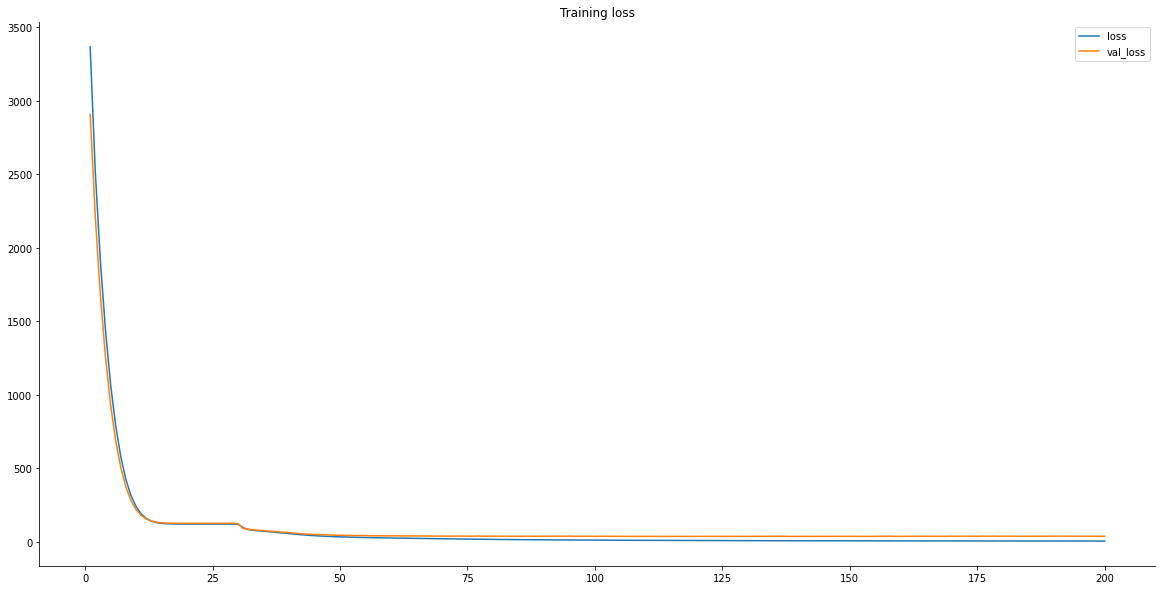

In [122]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.figure(figsize=(20, 10))
plt.plot(history["epoch"], history["loss"])
plt.plot(history["epoch"], history["val_loss"])
plt.title("Training loss")
plt.legend(["loss", "val_loss"])

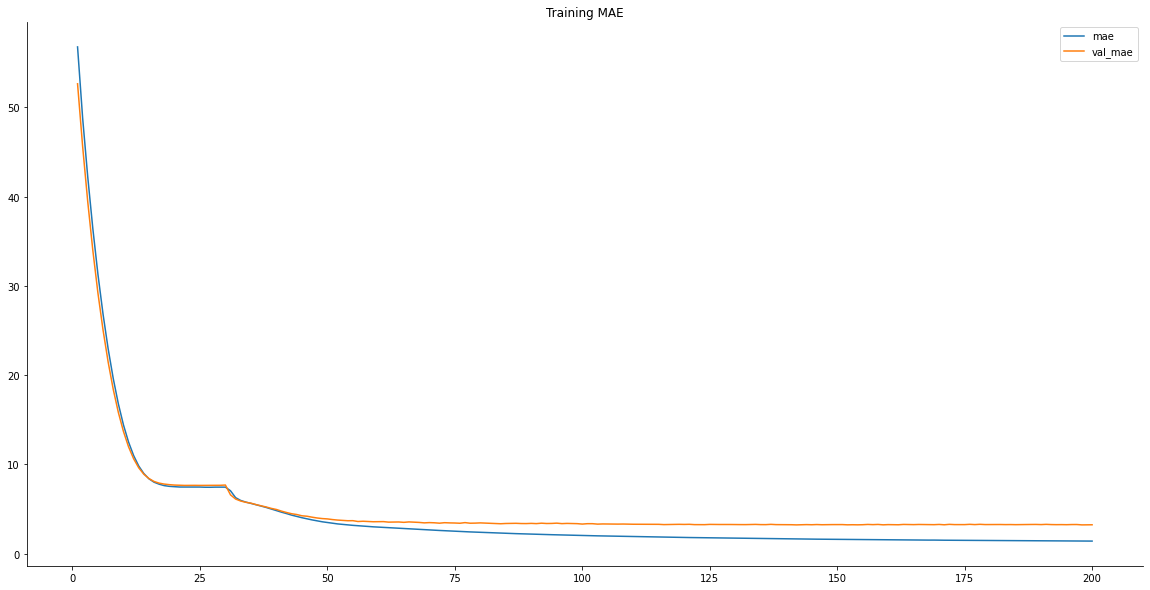

In [115]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

plt.figure(figsize=(20, 10))
plt.plot(history["epoch"], history["mae"])
plt.plot(history["epoch"], history["val_mae"])
plt.title("Training MAE")
plt.legend(["mae", "val_mae"])

In [91]:
def evaluate(test_sample: data.batch.DataBatch, mean: float, std: float):
    with torch.no_grad():
        test_sample = test_sample.to(device)
        pred = model(test_sample)
    truth = test_sample.y
    
    y_truth = un_z_score(truth, mean, std)
    y_pred = un_z_score(pred, mean, std)
    
    return y_truth, y_pred

In [104]:
test_sample = next(test_loader._get_iterator())
y_truth, y_pred = evaluate(
    test_sample,
    test_loader.dataset.mean,
    test_loader.dataset.std,
)

In [105]:
y_truth = torch.flatten(y_truth)
y_pred = torch.flatten(y_pred)

In [107]:
y_truth = y_truth[:config["N_SLOT"]]
y_pred = y_pred[:config["N_SLOT"]]

In [110]:
mape(y_truth, y_pred).item()

0.0367380333891076

In [111]:
y_pred = y_pred.cpu().detach().numpy().tolist()
y_truth = y_truth.cpu().detach().numpy().tolist()

Text(0.5, 1.0, 'Comparison truth - prediction of day k')

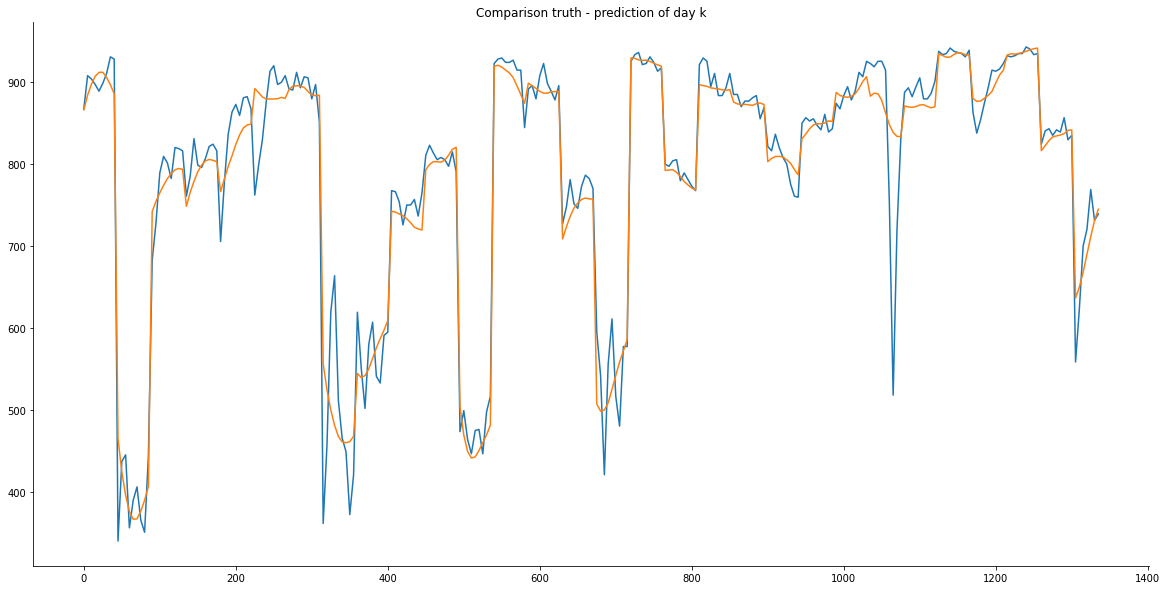

In [120]:
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
plt.figure(figsize=(20, 10))


plt.plot(range(0, config["N_SLOT"] * 5, 5), y_truth)

plt.plot(range(0, config["N_SLOT"] * 5, 5), y_pred)
plt.title("Comparison truth - prediction of day k")